In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import json
from IPython.display import display
from ipyleaflet import Map, Marker, GeoJSON, basemaps
from ipywidgets import interact, widgets, interactive
from shapely.geometry import Point

In [7]:
# Load forest loss data

forest_loss_data = pd.read_csv("treecover_loss__ha.csv")
 
# Load forest fire data
forest_fire_data = pd.read_csv("treecover_loss_from_fires_by_region__ha.csv")


# Explore the structure of the data
forest_loss_data.head()
forest_fire_data.head()

# Define Region of Interest (ROI)
roi_country = 'AUS'

# Merge data frames on 'iso' and 'umd_tree_cover_loss__year'
merged_data = pd.merge(forest_loss_data, forest_fire_data, on=['iso', 'umd_tree_cover_loss__year'])

# Filter data for the specified ROI
australia_data = merged_data[merged_data['iso'] == roi_country]


Total Forest Loss: 8846937.6 ha
Forest Loss from Fires: 6319457.85 ha
Total Gross Emissions: 2298535084.89 Mg CO2e


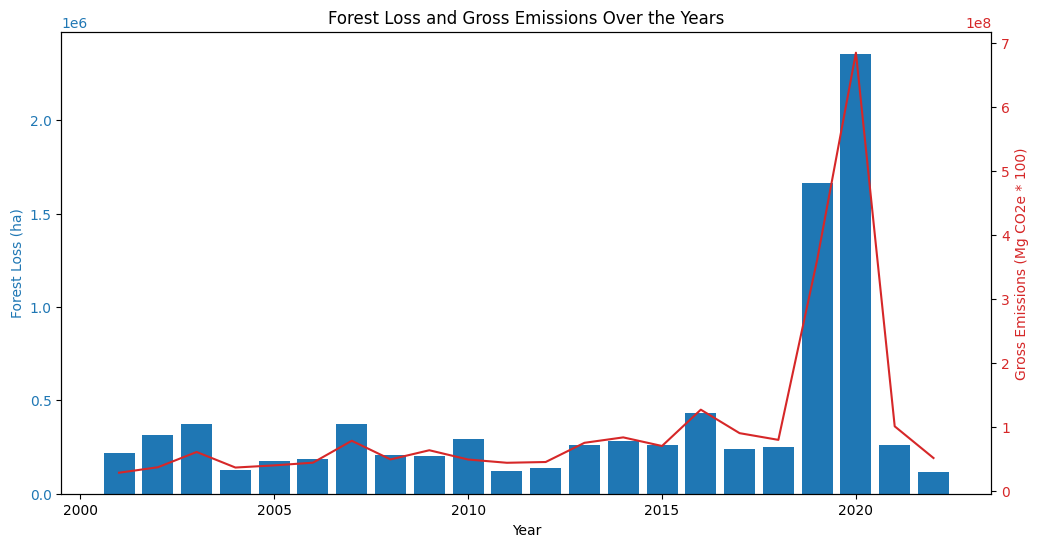

interactive(children=(IntSlider(value=2001, description='year', max=2022, min=2001), Output()), _dom_classes=(…

In [8]:
# Basic analysis - Total forest loss, fire-induced loss, and emissions
#CO2e means the number of metric tons of CO2 emissions with the same global warming potential as one metric ton of another greenhouse gas
try:
    total_loss = merged_data['umd_tree_cover_loss__ha_x'].sum()
    fire_loss = merged_data['umd_tree_cover_loss_from_fires__ha'].sum()
    total_emissions = merged_data['gfw_gross_emissions_co2e_all_gases__Mg'].sum()

    # Display results
    print(f"Total Forest Loss: {round(total_loss, 2)} ha")
    print(f"Forest Loss from Fires: {round(fire_loss, 2)} ha")
    print(f"Total Gross Emissions: {round(total_emissions, 2)} Mg CO2e")
    
    # Visualization
    # Using 'umd_tree_cover_loss__year' as the column representing years in the DataFrame
    years = merged_data['umd_tree_cover_loss__year'].unique()

    # Create initial figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot bar graph for forest loss and fire-induced loss
    bar = ax1.bar(years, merged_data.groupby('umd_tree_cover_loss__year')['umd_tree_cover_loss__ha_x'].sum(), label='Forest Loss')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Forest Loss (ha)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for the line graph
    ax2 = ax1.twinx()
    line, = ax2.plot(years, merged_data.groupby('umd_tree_cover_loss__year')['gfw_gross_emissions_co2e_all_gases__Mg'].sum(), color='tab:red', label='Gross Emissions')
    ax2.set_ylabel('Gross Emissions (Mg CO2e * 100)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Adding a title to the graph
    plt.title('Forest Loss and Gross Emissions Over the Years')

    # Function to update the graph based on the selected year
    def update_graph(year):
        selected_data = merged_data[merged_data['umd_tree_cover_loss__year'] == year]
        bar[0].set_height(selected_data['umd_tree_cover_loss__ha_x'].iloc[0])  # Only one bar for the selected year
        line.set_ydata(selected_data['gfw_gross_emissions_co2e_all_gases__Mg'] * 100)
        plt.show()

        # Display numerical data
        print(f"\033[1m\033[94mYear: {year}\033[0m")
        total_tree_loss = selected_data['umd_tree_cover_loss__ha_x'].sum()
        total_forest_fire = selected_data['umd_tree_cover_loss_from_fires__ha'].sum()
        print(f"\033[1m\033[91mTotal Tree Loss: {round(total_tree_loss, 2)} ha\033[0m")
        print(f"\033[1m\033[91mTotal Forest Fire per ha: {round(total_forest_fire, 2)} ha\033[0m")


    # Creating an interactive slider using the interactive function
    interactive_plot = interactive(update_graph, year=widgets.IntSlider(min=min(years), max=max(years), step=1, value=min(years)))
    display(interactive_plot)

except KeyError as e:
    # Print the error message to identify any missing column
    print(f"KeyError: {e}")
    # Print the columns of the merged DataFrame
    print("Merged Data Columns:")
    print(merged_data.columns)


In [9]:
# Loading the CSV file with forest data
forest_csv_path = "ForestsMetadataAUS.csv"

forest_df = pd.read_csv(forest_csv_path, encoding='ISO-8859-1')

# Convert DMS coordinates to decimal degrees
def dms_to_decimal(degrees, minutes, seconds, direction):
    decimal_degrees = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction == 'S' or direction == 'W':
        decimal_degrees *= -1  # To add a negative sign for South and West
    return decimal_degrees

# Extract numeric values from latitude and longitude columns
forest_df['latitude'] = forest_df['latitude'].str.extract('(\d+\.\d+)')
forest_df['longitude'] = forest_df['longitude'].str.extract('(\d+\.\d+)')
forest_df['latitude'] = forest_df.apply(lambda row: dms_to_decimal(row['latitude'], 0, 0, 'S'), axis=1)
forest_df['longitude'] = forest_df.apply(lambda row: dms_to_decimal(row['longitude'], 0, 0, 'E'), axis=1)

# Create a GeoDataFrame with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(forest_df['longitude'], forest_df['latitude'])]
forest_gdf = gpd.GeoDataFrame(forest_df, geometry=geometry, crs="EPSG:4326")

# Create a simple map with point markers
australia_map = Map(center=(-25, 135), zoom=4, basemap=basemaps.Esri.NatGeoWorldMap)
geojson_data = json.loads(forest_gdf.to_json())
geojson_layer = GeoJSON(data=geojson_data, style={'color': 'red', 'radius': 5, 'fillColor': 'red', 'fillOpacity': 0.6})
australia_map.add_layer(geojson_layer)
display(australia_map)


# Creating widgets
year_range_slider = widgets.IntRangeSlider(value=[merged_data['umd_tree_cover_loss__year'].min(), merged_data['umd_tree_cover_loss__year'].max()],
                                           min=merged_data['umd_tree_cover_loss__year'].min(),
                                           max=merged_data['umd_tree_cover_loss__year'].max(),
                                           step=1,
                                           description='Select Year Range:')

data_source_checkbox = widgets.Checkbox(value=True,
                                        description='Include Forest Loss',
                                        disabled=False)

analysis_button = widgets.Button(description='Perform Analysis',
                                 button_style='success')

analysis_type_radio = widgets.RadioButtons(options=['Total Loss', 'Fire-Induced Loss', 'Emissions'],
                                           value='Total Loss',
                                           description='Select Analysis Type:')

# Create an Output widget for displaying interpretation
interpretation_output = widgets.Output()

# Display widgets and interpretation output
display(year_range_slider)
display(data_source_checkbox)
display(analysis_type_radio)
display(analysis_button)
display(interpretation_output)


# Function to perform analysis based on widget values
def perform_analysis(b):
    selected_years = range(year_range_slider.value[0], year_range_slider.value[1] + 1)
    
    selected_data = merged_data[merged_data['umd_tree_cover_loss__year'].isin(selected_years)]
    
    with interpretation_output:
        interpretation_output.clear_output()  # Clear previous output
        
        if data_source_checkbox.value:
            # Include Forest Loss in the analysis
            total_loss = selected_data['umd_tree_cover_loss__ha_x'].sum()
            print(f"Total Forest Loss: {total_loss:.2f} ha")
        
        if analysis_type_radio.value == 'Fire-Induced Loss':
            # Include Fire-Induced Loss in the analysis
            fire_loss = selected_data['umd_tree_cover_loss_from_fires__ha'].sum()
            print(f"Fire-Induced Loss: {fire_loss:.2f} ha")
        
        if analysis_type_radio.value == 'Emissions':
            # Include Emissions in the analysis
            total_emissions = selected_data['gfw_gross_emissions_co2e_all_gases__Mg'].sum()
            print(f"Total Gross Emissions: {total_emissions:.2f} Mg CO2e")
        
        # Add interpretation text
        print("\nInterpretation:")
        print("The analysis of forest loss in Australia reveals critical insights into the environmental challenges faced by the country. Here are key interpretations:")
        print("\nTotal Forest Loss:")
        print("Australia has experienced a substantial loss of approximately 8,846,937.60 hectares of forest. This alarming figure underscores the severity of deforestation, emphasizing the need for conservation measures to protect biodiversity and ecosystem health.")
        print("\nForest Loss from Fires:")
        print("A significant portion, around 6,319,457.85 hectares, can be attributed to forest fires. This highlights the vulnerability of Australian forests to fire-related damages, which can be influenced by various factors such as climate change and human activities.")
        print("\nTotal Gross Emissions:")
        print("The cumulative gross emissions amount to 2,298,535,084.89 Mg CO2e. This indicates the environmental impact associated with the loss of vegetation, contributing to the overall greenhouse gas emissions.")
        print("\nYearly Analysis – 2001:")
        print("In the year 2001, the analysis identified a total tree loss of 218,816.30 hectares, with a forest fire impact of 154,497.15 hectares. This specific year’s data suggests potential environmental events or anthropogenic activities contributing to the observed forest changes.")
        print("\nOverall Implications:")
        print("The findings underscore the urgency of implementing sustainable forest management practices in Australia. Addressing the drivers of deforestation, particularly forest fires, is crucial for mitigating environmental degradation and promoting long-term ecological sustainability. The detailed yearly analysis facilitates a targeted approach to conservation efforts, helping policymakers and environmentalists make informed decisions to protect Australia’s diverse ecosystems.")

# Link the button click event to the analysis function
analysis_button.on_click(perform_analysis)

Map(center=[-25, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

IntRangeSlider(value=(2001, 2022), description='Select Year Range:', max=2022, min=2001)

Checkbox(value=True, description='Include Forest Loss')

RadioButtons(description='Select Analysis Type:', options=('Total Loss', 'Fire-Induced Loss', 'Emissions'), va…

Button(button_style='success', description='Perform Analysis', style=ButtonStyle())

Output()